# Building a fine-tuned translation system for English-Malayalam

- toc: true
- branch: master
- badges: true
- hide_binder_badge: true
- comments: true
- author: Kurian Benoy
- categories: [fastai, huggingface, translation, fine tuning, malayalam]
- search_exclude: false
- hide: false

Hey, everyone. We all are familiar with translation systems like using google translate. So today, let's build a fine tuned translation system for converting text from english to malayalam. It's built using Blurr library - built on top of Hugging face and fast.ai made by [Wayde Gilliam](https://twitter.com/waydegilliam). Also our translation system is going to be fine tuned on [top of KDE specific dataset](https://huggingface.co/datasets/kde4). You can find the trained model [here](https://huggingface.co/kurianbenoy/kde_en_ml_translation_model).


![Google Translate](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Screenshot_of_Google_Translate.png/1200px-Screenshot_of_Google_Translate.png)

**Installation**

In [1]:
#collapse
! python3 -m pip install -Uqq datasets== fastai==2.6.3
! python3 -m pip install -Uqq transformers[sentencepiece]
! python3 -m pip install -Uqq ohmeow-blurr==1.0.5
! python3 -m pip install -Uqq nltk
! python3 -m pip install -Uqq sacrebleu
! python3 -m pip install -Uqq  git+https://github.com/huggingface/huggingface_hub#egg=huggingface-hub["fastai"]

ERROR: Could not find a version that satisfies the requirement datasets== (from versions: 0.0.9, 1.0.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0, 1.2.1, 1.3.0, 1.4.0, 1.4.1, 1.5.0, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.8.0, 1.9.0, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.2, 1.13.3, 1.14.0, 1.15.0, 1.15.1, 1.16.0, 1.16.1, 1.17.0, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 2.0.0, 2.1.0, 2.2.0)
ERROR: No matching distribution found for datasets==


---
## Loading Data

A translation system is an example of [sequence to sequence models](https://huggingface.co/course/chapter1/7?fw=pt), which is usually used for tasks which involves generating new data. Translation usually needs datasets in both the source language and target language (the language to which it needs to be translated).

We are using [KDE4 datasets](https://huggingface.co/datasets/kde4), and choose both source language and translation language as english and malayalam respectively. Usually these datasets are curated by community volunteers to their native language, and this was probably done by KDE community volunteers in Kerala. When someone is localizing these texts into there in local languague, usually computer science specific terms are still written in english.

In [2]:
import pandas 
from datasets import load_dataset

In [3]:
raw_datasets = load_dataset("kde4", lang1="en", lang2="ml", split="train[:1000]")

Using custom data configuration en-ml-lang1=en,lang2=ml
Reusing dataset kde4 (/home/.cache/huggingface/datasets/kde4/en-ml-lang1=en,lang2=ml/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac)


Most of translation dataset is in form of id and translation json output - with both `en` and `ml` as objects.

In [4]:
raw_datasets[0]

{'id': '0',
 'translation': {'en': 'Add Feed to Akregator',
  'ml': 'അക്രിഗേറ്ററില്\u200d ഫീഡ് കൂട്ടിച്ചേര്\u200dക്കുക'}}

---
## Transforming data into DataLoaders

### Importing libraries and get hugging-face objects

In [5]:
from blurr.text.data.all import *
from blurr.text.modeling.all import *
from blurr.text.utils import *

from fastai.data.all import *
from fastai.callback.all import *
from fastai.learner import load_learner, Learner
from fastai.optimizer import *
from transformers import *

In [6]:
#hide-output
pretrained_model_name = "Helsinki-NLP/opus-mt-en-ml"
model_cls = AutoModelForSeq2SeqLM
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=model_cls)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

loading configuration file https://huggingface.co/Helsinki-NLP/opus-mt-en-ml/resolve/main/config.json from cache at /home/.cache/huggingface/transformers/ae9605b10d5542ca400f6f0891bb2ee75d9734555fcbbf74ad987eb03c41e049.e9f57d60c3a147cc9716cf6c6cdf1e03ff2738471f36ac092b54dc7816cce404
Model config MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-en-ml",
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      24660
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 24660,
  "decoder_vocab_size": 24661,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layer

('marian',
 transformers.models.marian.configuration_marian.MarianConfig,
 transformers.models.marian.tokenization_marian.MarianTokenizer,
 transformers.models.marian.modeling_marian.MarianMTModel)

In [7]:
translation_df = pd.DataFrame(raw_datasets["translation"], columns=["en", "ml"])
translation_df.head()

,en,ml
0,Add Feed to Akregator,അക്രിഗേറ്ററില്‍ ഫീഡ് കൂട്ടിച്ചേര്‍ക്കുക
1,Add Feeds to Akregator,അക്രിഗേറ്ററില്‍ ഫീഡുകള്‍ കൂട്ടിച്ചേര്‍ക്കുക
2,Add All Found Feeds to Akregator,എല്ലാ ഫീഡുകളും അക്രിഗേറ്ററില്‍ കൂട്ടിച്ചേര്‍ക്കുക
3,Subscribe to site updates (using news feed),സൈറ്റുകളിലെ പുതുമകളറിയാന്‍ വരിക്കാരനാകുക (വാര്‍ത്താ ഫീഡുകള്‍ ഉപയോഗിച്ചു്)
4,Imported Feeds,എടുത്ത ഫീഡുകള്‍


In [8]:
blocks = (Seq2SeqTextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader("en"), get_y=ColReader("ml"), splitter=RandomSplitter())

In [9]:
dls = dblock.dataloaders(translation_df, bs=16)
dls.show_batch(dataloaders=dls, max_n=2, input_trunc_at=100, target_trunc_at=250)

,text,target
0,A▁version▁control▁history▁entry▁consists of▁several▁lines.▁Specify the▁regular▁expression▁to▁detect,ഒരു ഭാഷാന്തര നിയന്ത്രണത്തിന്റെ നാള്വഴി ചേര്ക്കുന്നതില് പല വരികളുണ്ടാകും. ആദ്യത്തെ വരി കണ്ടുപിടിക്കാനുള്ള നിത്യഭാവം നിര്ദ്ദേശിക്കുക (മുന്നിലെ വിശദീകരണം കൂടാതെ). ഇനം തിരിക്കാനുപയോഗിക്കുന്ന കീകളെ ഒന്നിച്ചാക്കാന് ബ്രാക്കറ്റുകള് ഉപയോഗിക്കുക. ഒഴിച്ചു വിട്ട
1,▁Mailody▁can▁store▁all▁attchements of▁all▁messages in▁a▁certain▁folder.▁Then▁you▁never▁have▁to▁save▁,"എല്ലാ സന്ദേശങ്ങളുടേയും എല്ലാ അനുബന്ധങ്ങളും ഒരു പ്രത്യേക അറയില് സൂക്ഷിക്കാന് മെയിലഡിക്ക് കഴിയും. നിങ്ങള്ക്കവയെ സന്ദേശങ്ങളില്നിന്ന് പ്രത്യേകം സൂക്ഷിക്കേണ്ടതില്ല. അവ അറയില് ഉണ്ടായിരിക്കും. പ്രത്യേകം ശ്രദ്ധിക്കുക, ഈ അറ ഇടക്കിടക്ക് കാലിയാക്കിക്കൊണ്ടിരിക്ക"


---
## Training fine-tuned translation system

### Using blurr High-level API

Bugs in ohmeow v1.0.4 has been fixed by the [open-source maintainer](https://github.com/ohmeow/).

In [10]:
from blurr.text.utils import BlurrText

NLP = BlurrText()

In [11]:
#hide-output
learn = BlearnerForTranslation.from_data(
    translation_df,
    pretrained_model_name,
    src_lang_name="English",
    src_lang_attr="en",
    trg_lang_name="Malayalam",
    trg_lang_attr="ml",
    dl_kwargs={"bs": 16},
)

loading configuration file https://huggingface.co/Helsinki-NLP/opus-mt-en-ml/resolve/main/config.json from cache at /home/.cache/huggingface/transformers/ae9605b10d5542ca400f6f0891bb2ee75d9734555fcbbf74ad987eb03c41e049.e9f57d60c3a147cc9716cf6c6cdf1e03ff2738471f36ac092b54dc7816cce404
Model config MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-en-ml",
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      24660
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 24660,
  "decoder_vocab_size": 24661,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layer

In [12]:
metrics_cb = BlearnerForTranslation.get_metrics_cb()
learn.fit_one_cycle(1, lr_max=4e-5, cbs=[metrics_cb])

[nltk_data] Downloading package wordnet to /home/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


epoch,train_loss,valid_loss,bleu,meteor,sacrebleu,time
0,5.512897,4.821253,0.023251,0.158193,4.086147,00:19


In [13]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)

,text,target,prediction
0,▁Mailody▁is▁able▁to▁convert▁your▁plain▁message▁to▁a▁html▁message▁and▁include▁that in the▁outgoing▁message.▁This▁means the▁receiver▁will▁also▁have▁clickable▁links▁and▁colored▁quote▁levels.,നിങ്ങളുടെ സാദാ സന്ദേശം എച്ച്ടിഎംഎല് സന്ദേശമാക്കി മാറ്റി അത് പുറത്തേക്ക് അയക്കുന്ന സന്ദേശത്തില് ഉള്പ്പെടുത്താന് മെയിലഡിക്കു കഴിയും. അതായത് ഞൊട്ടാവുന്ന കണ്ണികളും വര്ണ്ണ ഉദ്ധരണി തലവും സ്വീകര്ത്താവിനുകൂടി ലഭ്യമാവും,"[നിങ്ങളുടെ സമ്പാദന സന്ദേശം ഒരു html സന്ദേശമാക്കി മാറ്റുവാനും പുറത്തുള്ള സന്ദേശത്തിൽ ഉൾ ക്കൊള്ളുന്ന സന്ദേശത്തിൽ ഉൾപ്പെടുത്തുവാനും Middiയ്ക്കു് കഴിയും. ഇതിനർത്ഥം റിക്കോർഡ് ചെയ്യാവുന്ന കണ്ണികള്ക്കും നിറങ്ങള്ക്കും വലക്കെട്ടുകളും നിറങ്ങള്ക്കു്., പതിപ്പ് നിയന്ത്രിത ചരിത്രത്തിന്റെ പ്രാരംഭമായതിന്റെ സാധാരണ പ്രയോഗം. സാധാരണയായി ഈ വരിയിൽ ""$2Loux"" കീവാതകം ഉണ്ട്. സ്വതവേയുള്ള മൂല്ല്യം: description from play played for play play for play for play play play for filme cout fillulume for for courtyourtime fume time ck., തുടങ്ങുന്നതിനായി, ""പുതിയ"" തെരഞ്ഞെടുത്ത് ആദ്യം ഒരു പുതിയ ഒപ്പ് ഉണ്ടാക്കുക. അപ്പോൾ നിങ്ങൾക്കു് തിരുത്താനും ഒപ്പുകളുടെ ശേഖരം സംരക്ഷിക്കാനും സാധിക്കും., തിരുത്ത് ചെയ്ത ഫയൽ സൂക്ഷിയ്ക്കുമ്പോൾ വരിയുടെ അവസാനങ്ങൾ സജ്ജീകരിയ്ക്കുന്നു. ഡോഎസ്/ ജാലകങ്ങൾ: CRS+LLF; യുഎഫ്: LRIFX; ഒപ്പം CRL++D=0, LRD=0A, LRFAA +0A, മുൻകാഴ്ചകൾ പരിശോധിക്കൽ പരാജയം. ഈ കമാൻഡ് പരിശോധിയ്ക്കുക:% 1 എന്ന ആജ്ഞ ഇപ്പോൾ പ്രവർത്തനരഹിതമായിരിക്കും., ""Subject"" അല്ലെങ്കിൽ 'suck' ഒരു ആഴത്തിലുള്ള അവസ്ഥയാണ്, സിസ്റ്റം പൂർണ്ണമായും അധികാരത്തിൽ കൊണ്ടുവരുന്നു, സസ്പെൻഡ് ഒരു നിദ്രാ സംസ്ഥാനമാണ്, സിസ്റ്റം ഊർജ്ജം കുറയ്ക്കുമ്പോള് മാത്രം ഊർജ്ജം സംഭരിക്കുക മാത്രമേ ഉള്ളൂ., ഈ മുൻകരുതൽ ലൈനിംഗ് ലൈനിംഗ് ലൈനിംഗ് വേളയിൽ മാത്രമേ ഉപയോഗമുള്ളു. ( വിശദാംശങ്ങൾക്ക് ഡോക്സ് കാണുക.), ഫയലിന്റെ പകർപ്പ് പ്രക്രിയയില് പിശക്: വായനയ്ക്കുള്ള ഫയൽ തുറക്കുന്നതിൽ പരാജയം:% 1, ▪ മാമോദീസ തുറന്നു നോക്കുകയും അടയ് ക്കുകയും ചെയ്യുന്നത് ക്രമമായ പ്രയോഗത്തിൽ ചേരുകയില്ല., എല്ലാ ഉപയോക്താക്കൾക്കും ആപ്പിൾട്ടുകൾ ഇൻസ്റ്റോൾ ചെയ്യുകയോ നീക്കം ചെയ്യുകയോ ചെയ്യുക., ഫയലിന്റെ പകർപ്പ് പ്രക്രിയയില് പിശക്: വായന പരാജയപ്പെട്ടു:% 1, വൈരുദ്ധ്യങ്ങളുടെ എണ്ണം സംബന്ധിച്ച് ഒരു സംവാദം കാണിക്കുക., നിങ്ങൾ ബാറ്ററി അധികാരത്തിൽ നിന്നും ഓടി രക്ഷപെടാൻ പോവുകയാണ്, ഇപ്പോൾ ഒന്നും ചെയ്യാനില്ല., വിലാസങ്ങള് ചേർത്തിട്ടില്ല. അയയ്ക്കുന്നതിന് മുമ്പ് കുറഞ്ഞത് ഒന്നെങ്കിലും ചേർക്കൂ., ക്ഷമിക്കണം, നിങ്ങളുടെ ഫോണൺ പതിപ്പ് പിന്തുണയ്ക്കുന്നില്ല.]"


### Using mid-level of blurr APIs

In [15]:
b = dls.one_batch()

In [16]:
len(b), b[0]["input_ids"].shape, b[1].shape

(2, torch.Size([16, 72]), torch.Size([16, 114]))

In [17]:
dls.show_batch(dataloaders=dls, input_trunc_at=250, target_trunc_at=250)

,text,target
0,"A▁version▁control▁history▁entry▁consists of▁several▁lines.▁Specify the▁regular▁expression▁to▁detect the▁first▁line (without the▁leading▁comment).▁Use▁parentheses▁to▁group the▁keys▁you▁want▁to▁use▁for▁sorting.▁If▁left▁empty,▁then▁KDiff3▁assumes▁that▁e",ഒരു ഭാഷാന്തര നിയന്ത്രണത്തിന്റെ നാള്വഴി ചേര്ക്കുന്നതില് പല വരികളുണ്ടാകും. ആദ്യത്തെ വരി കണ്ടുപിടിക്കാനുള്ള നിത്യഭാവം നിര്ദ്ദേശിക്കുക (മുന്നിലെ വിശദീകരണം കൂടാതെ). ഇനം തിരിക്കാനുപയോഗിക്കുന്ന കീകളെ ഒന്നിച്ചാക്കാന് ബ്രാക്കറ്റുകള് ഉപയോഗിക്കുക. ഒഴിച്ചു വിട്ട
1,"▁There▁is▁no▁Inbox▁found in▁any▁resource.▁Starting▁a▁new▁message▁will▁cause the▁message▁to▁be▁lost▁after▁you▁have▁sent▁it.▁You▁will▁not▁have▁a▁local▁copy▁anymore.▁If▁you▁want▁a▁copy,▁one▁way▁to▁do▁this▁is▁to▁add▁yourself▁as▁a CC▁to the▁message.<pad><",വിഭവങ്ങളിലൊന്നും ഒരു ഇന്ബോക്സ് കാണുന്നില്ല. ഒരു പുതിയ സന്ദേശം തുടങ്ങുന്നത് അത് അയച്ച ശേഷം നഷ്ടപ്പെടാന് കാരണമാകും. പ്രാദേശിക പകര്പ്പുകളൊന്നും ഒരിക്കലും ലഭ്യമല്ലാതാവും. ഉദാഹരണമായി ഒരു പകര്പ്പ് ആവശ്യമുണ്ടെങ്കില് ഒരു കാര്ബണ് പതിപ്പുകൂടി കൂട്ടിച്ചേര്ത്തതാ
2,"▁To▁prevent▁data▁loss▁or▁other▁damage,▁you▁can▁have the▁system suspend▁or▁hibernate,▁so▁you▁do▁not▁accidentally▁run▁out of▁battery▁power.▁Configure the▁number of▁minutes▁below▁which the▁machine▁will▁run the▁configured▁action.<pad><pad><pad><pad><pad>","വിവരനഷ്ടമോ ഹാനിയോ തടയാന്, സിസ്റ്റം മയങ്ങുകയോ ശിശിരനിദ്രയിലാകുകയോചെയ്യാവുന്നതാണ്, അങ്ങനെ ആകസ്മികമായിട്ടുപോലും ബാറ്ററി ഊര്ജ്ജം തീരാതിരിയ്ക്കും. ക്രമീകരിച്ച നടപടിയുമായി മുന്നോട്ടു് പോകേണ്ടതു് എത്ര മിനിറ്റുകളില് താഴെയാകുമ്പോഴാണെന്നു് താഴെ ക്രമീകരിയ്ക്കുക"
3,▁AutoSync▁is▁a▁feature▁from MP3tunes▁which▁allows▁you▁to▁automatically▁move▁your▁music▁between▁computers▁and▁devices.▁You▁can▁upload▁music▁from▁one▁location▁and▁have▁it▁download▁instantly▁to▁other▁locations.<pad><pad><pad><pad><pad><pad><pad><pad><pa,Enable harmony
4,"▁Regular▁expression▁for▁lines▁where▁KDiff3▁should▁automatically▁choose▁one▁source.▁When▁a▁line▁with▁a▁conflict▁matches the▁regular▁expression▁then -▁if▁available - C,▁otherwise B▁will▁be▁chosen.<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><","കെഡിഫ്3 സ്വതന്ത്രമായി ഒരു സ്രോതസ്സ് തെരഞ്ഞെടുക്കുന്നിടത്ത് വരികള്ക്കുള്ള നിത്യഭാവം. സംഘട്ടനമുള്ള വരി ചേര്ന്നുവരുമ്പോള് അതിന്റെ നിത്യഭാവം - സി ഉണ്ടെങ്കില് അത്, അല്ലെങ്കില് ബി തെരഞ്ഞെടുക്കപ്പെടും."
5,▁Loading▁external▁images▁gives▁spammers the▁acknowledgement▁that▁you▁received▁this▁message▁so▁they▁will▁use▁your▁email▁address▁to▁spam▁you.▁So▁you▁should▁only▁continue▁for▁very▁trusted▁messages.<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><,പുറമെനിന്നൊരു ചിത്രം കയറ്റുന്നത് നിങ്ങള്ക്ക് ഈ സന്ദേശം ലഭിച്ചെന്ന മടക്കരശീതി ചവറയയ്ക്കുന്നവര്ക്ക് ലഭിച്ചേക്കാം. അവര് നിങ്ങളുട ഇതപാല് വിലാസം നിങ്ങള്ക്കു് നേരേയും ചവറയയ്ക്കാനുപയോഗിച്ചേക്കാം. അതുകൊണ്ട് വളരെ വിശ്വസ്ത സന്ദേശങ്ങള് മാത്രം തുടര്ന്നാല് മതി.
6,▁Mailody▁is▁able▁to▁convert▁your▁plain▁message▁to▁a▁html▁message▁and▁include▁that in the▁outgoing▁message.▁This▁means the▁receiver▁will▁also▁have▁clickable▁links▁and▁colored▁quote▁levels.<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa,നിങ്ങളുടെ സാദാ സന്ദേശം എച്ച്ടിഎംഎല് സന്ദേശമാക്കി മാറ്റി അത് പുറത്തേക്ക് അയക്കുന്ന സന്ദേശത്തില് ഉള്പ്പെടുത്താന് മെയിലഡിക്കു കഴിയും. അതായത് ഞൊട്ടാവുന്ന കണ്ണികളും വര്ണ്ണ ഉദ്ധരണി തലവും സ്വീകര്ത്താവിനുകൂടി ലഭ്യമാവും
7,▁You▁have▁clicked▁on▁a▁link▁which▁might▁not▁indicate▁correctly▁where▁you▁are▁really▁going▁to.▁Please▁check▁if▁you▁really▁want▁to▁view▁a▁page▁on▁this▁server:▁%1▁Do▁you▁want▁to▁go▁there?<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><,നിങ്ങള് ഒരു കണ്ണിയില് ഞൊട്ടിയത് നിങ്ങളെവിടേക്കാണ് വാസ്തവത്തില് പോകുന്നത് എന്ന് കൃത്യമായി സൂചിപ്പിക്കുന്നില്ല. ഇ സേവകന്റെ താളിലേക്കു തന്നെ യാണോ പോകേണ്ടതെന്ന് പരിശോധിക്കുക:% 1 നിങ്ങള്ക്കിവിടെ പോകണോ?
8,▁Try▁to▁align B▁and C▁when▁comparing▁or▁merging▁three input▁files.▁Not▁recommended▁for▁merging▁because▁merge▁might▁get▁more▁complicated. (Default▁is▁off.)<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><,അകത്തുവിടാനുള്ള 3ഫയലുകള് താരതമ്യമ് ചെയ്യുമ്പോഴോ ലയനം നടത്തുമ്പോഴോബിയും സിയും ന

In [18]:
seq2seq_metrics = {"bleu": {"returns": "bleu"}, "meteor": {"returns": "meteor"}, "sacrebleu": {"returns": "score"}}

model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat()
    cbs=learn_cbs,
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
)

learn.freeze()

[nltk_data] Downloading package wordnet to /home/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


SuggestedLRs(minimum=0.00010000000474974513, steep=2.75422871709452e-06, valley=0.00013182566908653826, slide=0.2089296132326126)

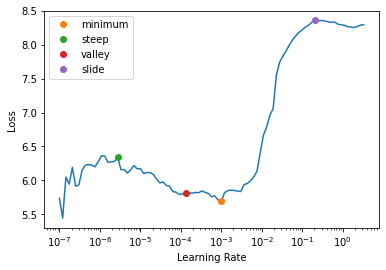

In [19]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [20]:
learn.fit_one_cycle(15, lr_max=5e-4, cbs=fit_cbs)

epoch,train_loss,valid_loss,bleu,meteor,sacrebleu,time
0,5.345715,4.811335,0.038182,0.183787,5.607312,00:15
1,4.658613,4.272337,0.058925,0.206963,3.932045,00:32
2,4.196794,4.031921,0.069354,0.167185,4.876618,00:25
3,3.826715,4.102871,0.071109,0.122637,4.639123,00:18
4,3.551352,4.046614,0.080512,0.202187,6.996449,00:26
5,3.329875,3.928597,0.054780,0.179460,3.403195,00:53
6,3.197556,3.818610,0.109263,0.212960,9.055532,00:21
7,3.034615,3.821332,0.100355,0.200819,8.208149,00:20
8,2.900438,3.807550,0.101014,0.222323,7.221607,00:35
9,2.820454,3.813579,0.111548,0.219794,9.026264,00:29


In [21]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=500)

,text,target,prediction
0,"▁With▁a▁dynamic▁playlist, Amarok▁becomes▁your▁own▁personal▁dj,▁automatically▁selecting▁tracks▁for▁you,▁based▁on▁a▁number of▁parameters▁that▁you▁select.",Turn dynamic mode on,"[Username for logins to disabled, format: Artist - Track (Album), from the currently playlist column name and token for playlist layouts, വരികളിലെ അക്ഷരങ്ങളുടെ അവസ്ഥ വിഗണിക്കുക. (മുന്നിലെ വിവരങ്ങളുമായി താരതമ്യം ചെയ്യാനും സിമുലേറ്ററിക്ക് കഴിയും.), ഒരു ടാബ് മാത്രമേ ഉപയോഗിക്കൂ. ഒരു ചെറിയ ടാബ് ബാറ്ററിയില്ലാതെ സ്വയം ടാബ് ബാറ്ററി യാന്ത്രികമായി മറയ്ക്കുന്നു. ഒരു ടാബ് മാത്രമേ ഉപയോഗിക്കൂ., ഇത്തരം പ്രകടനം തുടങ്ങുമ്പോള്꠱, മെയിലഡികളിൽ ചിരിച്ചതായി സ്വയമേവ ലയിപ്പിക്കുക. ഉദാഹരണമായി ഒരു അക്ഷരരൂപം പരിശോധിക്കുന്നുണ്ടോയെന്ന് പരിശോധിക്കാതെ സ്വയം ചിരിച്ചുകൊണ്ടാവും., മുന്꠱ജ്ജ് ഉപയോഗിച്ചുകൊണ്ട് പരാജയപ്പെട്ടു. ഈ ആജ്ഞ പരിശോധിക്കൂ:% 1 മുന്꠱നടപടി ആജ്ഞ ഇപ്പോൾ പ്രവര് പശ്ചാത്തപിക്കുകത്തനരഹിതമാക്കും., പുറമെനിന്ന്- മിച്ചമുള്ള മട്ടും പ്രാവർത്തികമാക്കുന്നു. വലിയ ഫയലുകളെക്കുറിച്ചുള്ള പരിശോധകന്റെ പരിശോധകനുഭവം വളരെ പതുക്കെയാവും., ഈ സ്ലൈഡനുപയോഗിച്ചു്, സിസ്റ്റം സോക്കറ്റ് പുറത്തേയ്ക്കു് പതിക്കുന്നു, പുറത്താക്കുവാനുള്ള മെയിലഡിഭാഗം ലഭ്യമല്ല, ദയവായി അത് അയക്കുന്നതിന് മുമ്പായി ക്രമീകരിയ്ക്കുക, ഈ മുന്꠱ പൂര്꠱വ്വ പ്രക്രിയയ്ക്കുള്ള സമയത്ത് വരിയില്꠱ മാത്രമേ ഉപയോഗിക്കൂ. (വിശദീകരണങ്ങള്ക്ക് പ്രമാണപത്രം നോക്കുക.), ഫയല്꠱ പകര്꠱പ്പെടുക്കുമ്പോള്꠱ പിശക്: ഫയലില്♬ വായനയ്ക്കുള്ള ഫയല്꠱ തുറക്കുന്നത് പരാജയപ്പെട്ടു. ഫയല് പശ്ചാത്തപിക്കുക നാമം:% 1, നിങ്ങളുപയോഗിക്കുന്ന ബീഗിള്꠱ ബാക്കെന് പശ്ചാത്തപിക്കുകഡുകള്꠱ തെരഞ്ഞെടുക്കുക., ഉപയോക്താവ്നാമം തിരിച്ചറിഞ്ഞിട്ടില്ല, അല്ലെങ്കിൽ പാറ്റേണുകളിലെ അടയാളമിടുക., അനുബന്ധങ്ങളുടെ അളവ്% 1 is new name for translate is the filter, representing the playlist column name and token for playlist layouts, ബാറ്ററികളിലെത്തിച്ചേരുമ്പോള്꠱ ശോഭ നിയന്ത്രിക്കുന്നു, (""ഒഴിഞ്ഞ ഇടങ്ങള്꠱ കാണിയ്ക്കുക"" പ്രവര്꠱ത്തമരഹിതമാക്കിയാല് പശ്ചാത്തപിക്കുക ഒഴിഞ്ഞ ഇടങ്ങളുടെ വ്യ അല്ലാഹുക്കള്꠱ ഒഴിവാക്കും.), മാതാപിതാക്കൾ തുറക്കുന്നതും അടയ്ക്കുന്നതും ലയിപ്പിക്കുന്നതും ലയിപ്പിക്കുക.]"


---
## Now let's translate with our trained models

### blurr top 3 translation predictions

In [22]:
test_text = "How are you doing"


outputs = learn.blurr_generate(test_text, key="translation_texts", num_return_sequences=3)
outputs

[{'translation_texts': ['എന്തൊക്കെയുണ്ട്?',
   'എങ്ങനെയുണ്ട്?',
   'എന്തൊക്കെയുണ്ട്.']}]

### Saving trained ML model

In [23]:
export_fname = "saved_model"


learn.metrics = None
learn.export(fname=f"{export_fname}.pkl")

In [24]:
from huggingface_hub import push_to_hub_fastai

push_to_hub_fastai(
    learn,
    "kurianbenoy/kde_en_ml_translation_model",
    commit_message="New version with 15 epoch of training",
)

/home/kurianbenoy/kde_en_ml_translation_model is already a clone of https://huggingface.co/kurianbenoy/kde_en_ml_translation_model. Make sure you pull the latest changes with `repo.git_pull()`.
W0511 16:57:02.992604 140162781013824 repository.py:685] /home/kurianbenoy/kde_en_ml_translation_model is already a clone of https://huggingface.co/kurianbenoy/kde_en_ml_translation_model. Make sure you pull the latest changes with `repo.git_pull()`.


Upload file model.pkl:   0%|          | 32.0k/221M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/kurianbenoy/kde_en_ml_translation_model
   62f36f9..766c8a0  main -> main

W0511 16:58:04.917035 140162781013824 repository.py:1144] remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/kurianbenoy/kde_en_ml_translation_model
   62f36f9..766c8a0  main -> main



'https://huggingface.co/kurianbenoy/kde_en_ml_translation_model/commit/766c8a06c07bb6352d0537ac1972d3c70360fd53'

### Prediction with our trained model

#### Correct Prediction

In [25]:
test_text = "How are you doing"

inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_translate(test_text)

[{'translation_texts': 'എന്തൊക്കെയുണ്ട്?'}]

In [26]:
test_text1 = "Add All Found Feeds to Akregator."

inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_translate(test_text1)

[{'translation_texts': 'എല്ലാ ഫീഡുകളും അക്രിഗേറ്ററില്꠱ കൂട്ടിച്ചേര് പശ്ചാത്തപിക്കുകക്കുക.'}]

#### Wrong Prediction

In [27]:
test_text2 = "Subscribe to site updates (using news feed)."

inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_translate(test_text2)

[{'translation_texts': 'സൈറ്റുകളിലെ പുതുമകളറിയാന്꠱ വരിക്കാരനാകുക (വാര്꠱ത്താ ഫീഡുകള്♬ ഉപയോഗിച്ചു്).'}]

Expected: 'സൈറ്റുകളിലെ പുതുമകളറിയാന്\u200d വരിക്കാരനാകുക (വാര്\u200dത്താ ഫീഡുകള്\u200d ഉപയോഗിച്ചു്

## Thanks to

- Wayde Gilliam - for creating blurr, and helping with doubts in translation bits
- Kevin Bird - for helping in editing the article.

fin.